In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, f1_score, log_loss
from sklearn.model_selection import learning_curve

In [9]:
# Load and prepare data
df = pd.read_csv(' ../../data_exploration/random_forest/cleaned_data.csv')
feature_columns = [col for col in df.columns if col not in ['b', 'e', 'CLASS', 'NSP']]
X = df[feature_columns]
y = df['NSP']

In [10]:
# Handle duplicates
df = df.drop_duplicates()

# Drop missing values
df = df.dropna()

df['NSP'] = df['NSP'].map({1.0: 0.0, 2.0: 1.0, 3.0: 2.0})

In [11]:
# Outlier handling
from scipy.stats import mstats
df['NSP'] = mstats.winsorize(df['NSP'], limits=[0.05, 0.05])  # Capping outliers

In [12]:
# Display basic info about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nTarget variable (NSP) distribution:")
print(df['NSP'].value_counts())
print("\nMissing values:")
print(df.isnull().sum().sum())

Dataset shape: (2119, 35)

First few rows:
       b       e   AC   FM   UC   DL   DS   DP     LB  ASTV  ...    C    D  \
0  240.0   357.0  0.0  0.0  0.0  0.0  0.0  0.0  120.0  73.0  ... -1.0 -1.0   
1    5.0   632.0  4.0  0.0  4.0  2.0  0.0  0.0  132.0  17.0  ... -1.0 -1.0   
2  177.0   779.0  2.0  0.0  5.0  2.0  0.0  0.0  133.0  16.0  ... -1.0 -1.0   
3  411.0  1192.0  2.0  0.0  6.0  2.0  0.0  0.0  134.0  16.0  ... -1.0 -1.0   
4  533.0  1147.0  4.0  0.0  5.0  0.0  0.0  0.0  132.0  16.0  ... -1.0 -1.0   

     E   AD   DE   LD   FS  SUSP  CLASS  NSP  
0 -1.0 -1.0 -1.0 -1.0  1.0  -1.0    9.0  1.0  
1 -1.0  1.0 -1.0 -1.0 -1.0  -1.0    6.0  0.0  
2 -1.0  1.0 -1.0 -1.0 -1.0  -1.0    6.0  0.0  
3 -1.0  1.0 -1.0 -1.0 -1.0  -1.0    6.0  0.0  
4 -1.0 -1.0 -1.0 -1.0 -1.0  -1.0    2.0  0.0  

[5 rows x 35 columns]

Column names:
['b', 'e', 'AC', 'FM', 'UC', 'DL', 'DS', 'DP', 'LB', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Ten

In [13]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

NameError: name 'rf_model' is not defined

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,  
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2, 
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [ ]:
# Predict and evaluate
y_pred = rf_model.predict(X_test_scaled)

f1 = f1_score(y_test, y_pred, average='weighted')
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print("Evaluation Results:")
print(f"F1 Score (Weighted): {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Evaluation Results:
F1 Score (Weighted): 0.9831
Balanced Accuracy: 0.9605


In [ ]:
# Calculate log loss
y_pred_proba = rf_model.predict_proba(X_test_scaled)  # Get probabilities for log loss
train_pred_proba = rf_model.predict_proba(X_train_scaled)
train_log_loss = log_loss(y_train, train_pred_proba)
test_log_loss = log_loss(y_test, y_pred_proba)
print(f"Training Log Loss: {train_log_loss:.4f}")
print(f"Test Log Loss: {test_log_loss:.4f}")

Training Log Loss: 0.0416
Test Log Loss: 0.0891


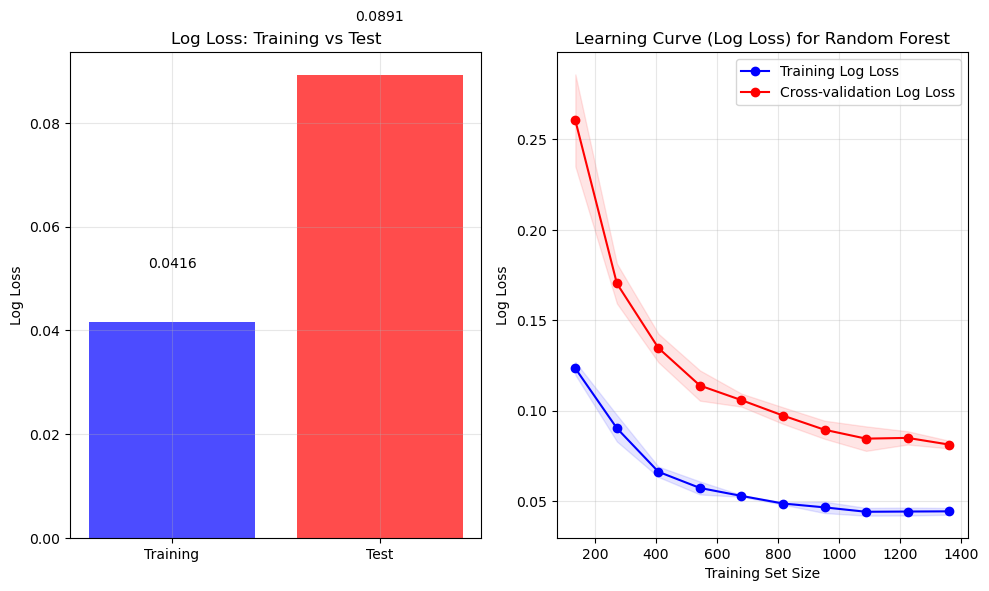

Overfitting Analysis:
Good generalization: Training and test log loss are close
Good performance: Test log loss is reasonable


In [ ]:
# Plot 1: Log Loss Comparison
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
loss_types = ['Training', 'Test']
loss_values = [train_log_loss, test_log_loss]
colors = ['blue', 'red']
bars = plt.bar(loss_types, loss_values, color=colors, alpha=0.7)
plt.ylabel('Log Loss')
plt.title('Log Loss: Training vs Test')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, loss_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.4f}', ha='center', va='bottom')

# Plot 2: Learning Curve for Log Loss
plt.subplot(1, 2, 2)
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train_scaled, y_train, cv=5, 
    scoring='neg_log_loss', train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Log Loss')
plt.plot(train_sizes, test_scores_mean, 'o-', color='red', label='Cross-validation Log Loss')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('Log Loss')
plt.title('Learning Curve (Log Loss) for Random Forest')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Overfitting analysis: Log loss over training iterations (for Random Forest)
print("Overfitting Analysis:")

if abs(train_log_loss - test_log_loss) < 0.1:
    print("Good generalization: Training and test log loss are close")
else:
    print("Potential overfitting: Large gap between training and test log loss")

if test_log_loss > 1.0:
    print("High test log loss: Model may need improvement")
else:
    print("Good performance: Test log loss is reasonable")